### Inciso a

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_vector_field_system(F_vector, x_range, y_range, grid_size=20, figsize=(10, 10), dpi=100, points=None):
    """
    Grafica el campo vectorial de un sistema de EDOs en el plano (y1, y2).
    
    :param F_vector: Lista de funciones que definen el sistema de EDOs.
    :param x_range: Rango para la variable y1.
    :param y_range: Rango para la variable y2.
    :param grid_size: Número de puntos en cada eje para la cuadrícula.
    :param figsize: Tamaño de la figura.
    :param dpi: Resolución de la figura.
    :param points: (Opcional) Puntos a marcar en la gráfica.
    """
    F = lambda t, y: [f(t, y) for f in F_vector]
    
    # Crear un grid de puntos en el espacio y1-y2
    y1 = np.linspace(x_range[0], x_range[1], grid_size)
    y2 = np.linspace(y_range[0], y_range[1], grid_size)
    Y1, Y2 = np.meshgrid(y1, y2)

    # Inicializar matrices
    U = np.zeros_like(Y1)
    V = np.zeros_like(Y2)

    # Asumimos t=0 para la visualización, si t no es relevante, puede omitirse
    t = 0  

    # Calcular las componentes de F(t, y1, y2)
    for i in range(grid_size):
        for j in range(grid_size):
            vec = F(t, [Y1[i, j], Y2[i, j]])
            U[i, j] = vec[0]
            V[i, j] = vec[1]

    # Configurar el tamaño de la figura y la resolución
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Dibujar el campo vectorial
    plt.quiver(Y1, Y2, U, V, color='blue')
    
    # Si se proporcionan puntos, marcarlos en el gráfico
    if points is not None:
        points = np.array(points)
        plt.scatter(points[:, 0], points[:, 1], color='red', marker='o', label='Ceros')
    
    plt.title('Campo Vectorial del Sistema de EDOs')
    plt.xlabel('y1')
    plt.ylabel('y2')
    plt.grid(True)
    plt.legend()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


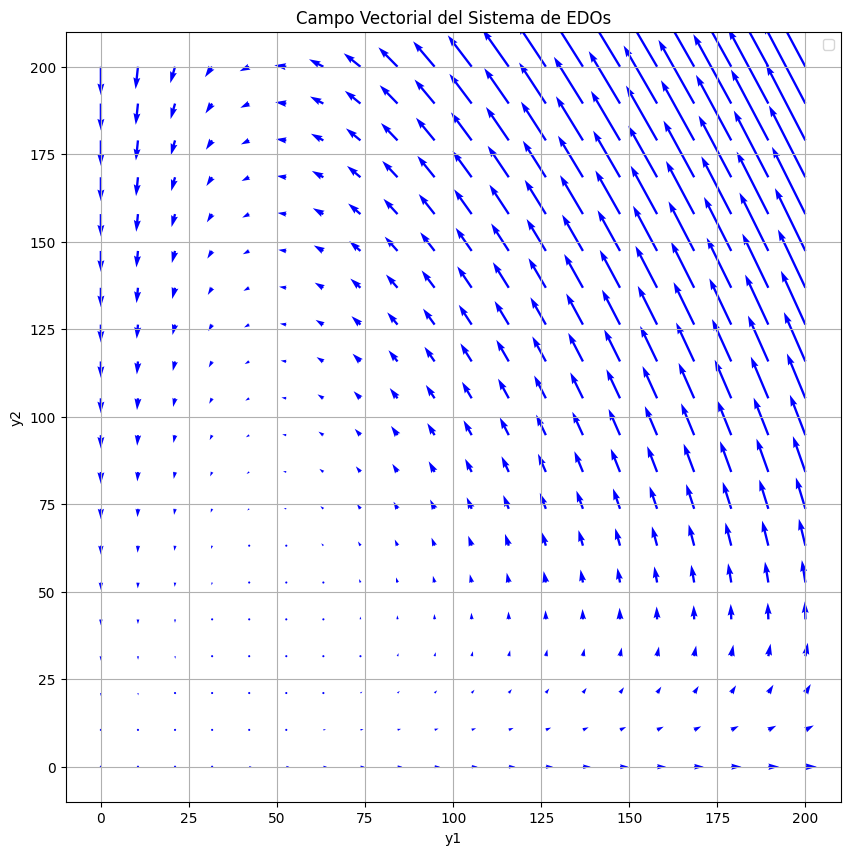

In [3]:
F_vector = [
    lambda t, y: 0.2 * y[0] - 0.005 * y[0] * y[1],  # x'(t) = 0.2x − 0.005xy
    lambda t, y: -0.5 * y[1] + 0.01 * y[0] * y[1]  # y'(t) = −0.5y + 0.01xy
]

# Rango de valores para x(t) y y(t)
x_range = [0, 200]  # Asumimos un rango razonable para la población x(t)
y_range = [0, 200]  # Asumimos un rango razonable para la población y(t)

# Graficar el campo vectorial
plot_vector_field_system(F_vector, x_range, y_range)

### Inciso b

In [26]:
from scipy.optimize import approx_fprime
from itertools import product
import numpy as np

def calc_derivadas_parciales(f, x0):
    grad = np.zeros(len(x0))
    for i in range(len(x0)):
        grad[i] = approx_fprime(x0, lambda x: f(x))[i]
    return grad

def newton(F, x0, max_iter, tol):
    eigenvalue = None
    for i in range(max_iter):
        F_x0 = np.array([f(x0) for f in F])
        dF_x0 = np.array([calc_derivadas_parciales(f, x0) for f in F])
        
        try:
            dF_x0_inv = np.linalg.inv(dF_x0)
        except np.linalg.LinAlgError:
            continue

        x0 = x0 - np.matmul(dF_x0_inv, F_x0)
        F_x0 = np.array([f(x0) for f in F])

        # Condición de parada de tolerancia
        if np.linalg.norm(F_x0, ord=2) < tol:
            eigenvalue = np.linalg.eigvals(dF_x0)
            break

    return x0, eigenvalue

def find_zeros(F, initial_points, maxIter=100, tol=1e-10):
    zeros = []
    for x0 in initial_points:
        zero, eigenvalue = newton(F, x0, maxIter, tol)
        
        # Solo proceder si eigenvalue no es None
        if eigenvalue is not None:
            # Redondear para evitar problemas de precisión
            zero_rounded = np.round(zero, decimals=7)
            eigenvalue_rounded = np.round(eigenvalue, decimals=7)

            # Filtrar duplicados
            is_unique = True
            for existing_zero, existing_eigenvalue in zeros:
                if np.allclose(existing_zero, zero_rounded, atol=tol) and np.allclose(existing_eigenvalue, eigenvalue_rounded, atol=tol):
                    is_unique = False
                    break

            if is_unique:
                zeros.append([zero_rounded, eigenvalue_rounded])

    return zeros

def generate_points(n, step, min_val, max_val):
    """
    Genera puntos en un espacio de n dimensiones con un salto específico,
    considerando un límite mínimo y máximo para cada dimensión.
    
    Parámetros:
    - n (int): Número de dimensiones.
    - step (float): Tamaño del salto entre puntos.
    - min_val (float): Límite mínimo para cada dimensión.
    - max_val (float): Límite máximo para cada dimensión.
    
    Retorna:
    - np.ndarray: Un arreglo de puntos en n dimensiones.
    """
    # Generar un rango de puntos en cada dimensión dentro de los límites especificados
    ranges = [np.arange(min_val, max_val + step, step) for _ in range(n)]
    
    # Usar el producto cartesiano para obtener todos los puntos
    points = np.array(list(product(*ranges)))
    
    return points



In [30]:
F = [
    lambda xy: 0.2 * xy[0] - 0.005 * xy[0] * xy[1],  # x'(t)
    lambda xy: -0.5 * xy[1] + 0.01 * xy[0] * xy[1]   # y'(t)
]

# Generar puntos iniciales en el primer cuadrante
initial_points = [
    np.array([0.1, 0.1]),
    np.array([50, 50]),
]

zeros = find_zeros(F, initial_points)

for z in zeros:
    v1, v2 = z[1]
    
    if isinstance(v1, complex):
        if v1.real > 0:
            tag = "Espiral repulsor"
        elif v1.real < 0:
            tag = "Espiral atractor"
        else:
            tag = "Centro"
    else:
        if v1 > 0 and v2 > 0:
            if v1 == v2:
                tag = "Twist repulsor"
            else:
                tag = "Nodo repulsor"
        elif v1 < 0 and v2 < 0:
            if v1 == v2:
                tag = "Twist atractor"
            else:
                tag = "Nodo atractor"
        else:
            tag = "Punto silla"
    
    print(f"Punto crítico: {z[0]}")
    print(f"Eigenvalores: {z[1]}")
    print(f"Clasificación: {tag}\n")

Punto crítico: [-0. -0.]
Eigenvalores: [ 0.2 -0.5]
Clasificación: Punto silla

Punto crítico: [50. 40.]
Eigenvalores: [-0.025+0.3526684j -0.025-0.3526684j]
Clasificación: Espiral atractor



### Inciso c

In [32]:
def runge_kutta_4_system(f, y0, t0, tf, h):
    """
    Método de Runge-Kutta de cuarto orden para un sistema de EDOs.
    
    :param f: Función que describe el sistema de EDOs.
    :param y0: Valores iniciales para y (vector).
    :param t0: Tiempo inicial.
    :param tf: Tiempo final.
    :param h: Paso de integración.
    :return: Valores de t y y calculados en cada paso.
    """
    n_steps = int((tf - t0) / h)
    t_values = np.linspace(t0, tf, n_steps + 1)
    y_values = np.zeros((n_steps + 1, len(y0)))
    
    y_values[0, :] = y0
    t = t0
    y = np.array(y0, dtype=float)

    for i in range(1, n_steps + 1):
        k1 = h * f(t, y)
        k2 = h * f(t + h/2, y + k1/2)
        k3 = h * f(t + h/2, y + k2/2)
        k4 = h * f(t + h, y + k3)
        
        y += (k1 + 2*k2 + 2*k3 + k4) / 6
        t += h
        y_values[i, :] = y

    return t_values, y_values

In [33]:
def system_of_eqs(t, y):
    """
    Define el sistema de ecuaciones diferenciales.
    y[0] = x, y[1] = y
    """
    dydt = np.zeros(2)
    dydt[0] = 0.2*y[0] - 0.005*y[0]*y[1]  # dx/dt = 0.2x − 0.005xy
    dydt[1] = -0.5*y[1] + 0.01*y[0]*y[1] # dy/dt = −0.5y + 0.01xy
    return dydt

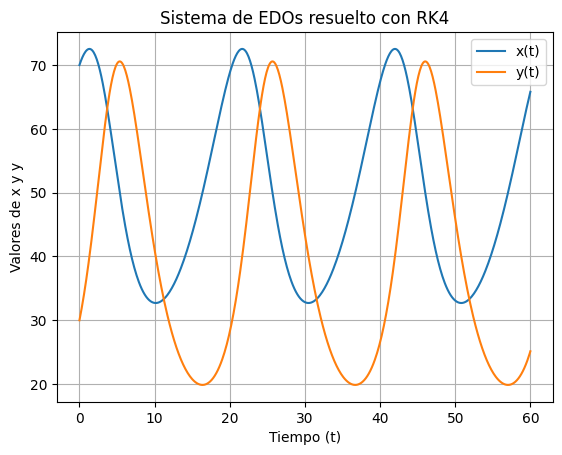

Último valor de x(t): 65.80281308173875
Último valor de y(t): 25.13725727333798
Período aproximado de x(t) basado en picos: 20.400000000000002 unidades de tiempo
Período aproximado de y(t) basado en picos: 20.300000000000004 unidades de tiempo


In [43]:
# Parámetros iniciales
y0 = [70, 30]  # x(0) = 70, y(0) = 30
t0 = 0
tf = 60
h = 0.1

# Resolver el sistema de EDOs usando RK4
t_values, y_values = runge_kutta_4_system(system_of_eqs, y0, t0, tf, h)

# Graficar los resultados
plt.plot(t_values, y_values[:, 0], label="x(t)")
plt.plot(t_values, y_values[:, 1], label="y(t)")
plt.xlabel("Tiempo (t)")
plt.ylabel("Valores de x y y")
plt.title("Sistema de EDOs resuelto con RK4")
plt.legend()
plt.grid(True)
plt.show()

# Obtener los últimos valores de x y y
x_final = y_values[-1, 0]  # Último valor de x(t)
y_final = y_values[-1, 1]  # Último valor de y(t)

print(f"Último valor de x(t): {x_final}")
print(f"Último valor de y(t): {y_final}")

from scipy.signal import find_peaks

# Encontrar los picos de x(t)
x_values = y_values[:, 0]
peaks, _ = find_peaks(x_values)

# Si hay al menos dos picos, calcular el período como la distancia entre ellos
if len(peaks) > 1:
    period = t_values[peaks[1]] - t_values[peaks[0]]
    print(f"Período aproximado de x(t) basado en picos: {period} unidades de tiempo")
else:
    print("No se detectaron suficientes picos para estimar el período")
    
# Encontrar los picos de y(t)
y_values = y_values[:, 1]  # Usar los valores de y(t) en lugar de x(t)
peaks, _ = find_peaks(y_values)

# Si hay al menos dos picos, calcular el período como la distancia entre ellos
if len(peaks) > 1:
    period_y = t_values[peaks[1]] - t_values[peaks[0]]
    print(f"Período aproximado de y(t) basado en picos: {period_y} unidades de tiempo")
else:
    print("No se detectaron suficientes picos para estimar el período de y(t)")

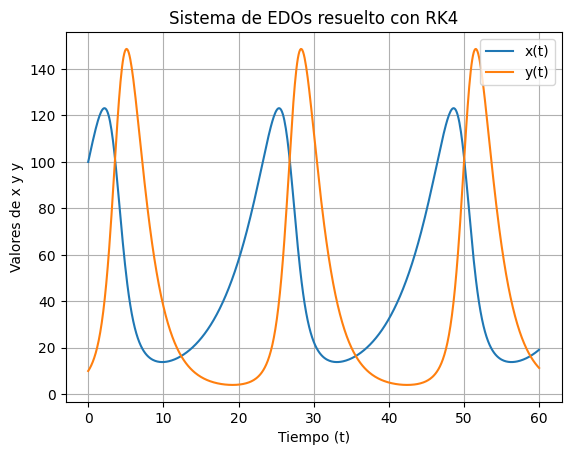

Último valor de x(t): 19.150564378249037
Último valor de y(t): 11.298504631881979
Período aproximado de x(t) basado en picos: 23.200000000000003 unidades de tiempo
Período aproximado de y(t) basado en picos: 23.2 unidades de tiempo


In [44]:
# Parámetros iniciales
y0 = [100, 10]  # x(0) = 100, y(0) = 10
t0 = 0
tf = 60
h = 0.1

# Resolver el sistema de EDOs usando RK4
t_values, y_values = runge_kutta_4_system(system_of_eqs, y0, t0, tf, h)

# Graficar los resultados
plt.plot(t_values, y_values[:, 0], label="x(t)")
plt.plot(t_values, y_values[:, 1], label="y(t)")
plt.xlabel("Tiempo (t)")
plt.ylabel("Valores de x y y")
plt.title("Sistema de EDOs resuelto con RK4")
plt.legend()
plt.grid(True)
plt.show()

# Obtener los últimos valores de x y y
x_final = y_values[-1, 0]  # Último valor de x(t)
y_final = y_values[-1, 1]  # Último valor de y(t)

print(f"Último valor de x(t): {x_final}")
print(f"Último valor de y(t): {y_final}")

from scipy.signal import find_peaks

# Encontrar los picos de x(t)
x_values = y_values[:, 0]
peaks, _ = find_peaks(x_values)

# Si hay al menos dos picos, calcular el período como la distancia entre ellos
if len(peaks) > 1:
    period = t_values[peaks[1]] - t_values[peaks[0]]
    print(f"Período aproximado de x(t) basado en picos: {period} unidades de tiempo")
else:
    print("No se detectaron suficientes picos para estimar el período")
    
# Encontrar los picos de y(t)
y_values = y_values[:, 1]  # Usar los valores de y(t) en lugar de x(t)
peaks, _ = find_peaks(y_values)

# Si hay al menos dos picos, calcular el período como la distancia entre ellos
if len(peaks) > 1:
    period_y = t_values[peaks[1]] - t_values[peaks[0]]
    print(f"Período aproximado de y(t) basado en picos: {period_y} unidades de tiempo")
else:
    print("No se detectaron suficientes picos para estimar el período de y(t)")